# Enforcement Violations Augmentation
---
This notebook demonstrates how to augment the enforcement violations dataset with a new feature:
- **Borough_name** (from MODZCTA csv dataset)

Steps include:
1. Load enforcement dataset.
2. Load MODZCTA polygons.
3. Parse WKT geometries and build a spatial index.
4. Perform point-in-polygon join to assign borough.
5. Save the augmented dataset.

In [ ]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Point
from shapely.strtree import STRtree
import numpy as np


## Load MODZCTA polygons

In [2]:
# Path to MODZCTA CSV (download from NYC Open Data)
modzcta_csv = "/Users/Marcy_Student/Desktop/MTA_DATATHON/MTA_Datathon_2025/Data/2020_Community_District_Tabulation_Areas__CDTAs__20250921.csv"

mod = pd.read_csv(modzcta_csv, low_memory=False)

# Convert WKT geometries to shapely Polygons
mod['geometry'] = mod['the_geom'].apply(wkt.loads)

# Create GeoDataFrame
gdf_mod = gpd.GeoDataFrame(mod, geometry='geometry', crs='EPSG:4326')

# Build spatial index for polygons
poly_geoms = gdf_mod['geometry'].tolist()
poly_index = STRtree(poly_geoms)

print("Loaded MODZCTA polygons:", len(poly_geoms))
gdf_mod.head()


Loaded MODZCTA polygons: 71


,BoroCode,BoroName,CountyFIPS,CDTA2020,CDTAName,CDTAType,Shape_Length,Shape_Area,the_geom,geometry
0,3,Brooklyn,47,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),0,65640.600849,1.316510e+08,MULTIPOLYGON (((-73.92405909736993 40.71411156...,"MULTIPOLYGON (((-73.92406 40.71411, -73.92404 ..."
1,3,Brooklyn,47,BK02,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,0,65273.412132,7.592072e+07,MULTIPOLYGON (((-73.96929296348496 40.70709333...,"MULTIPOLYGON (((-73.96929 40.70709, -73.96913 ..."
2,3,Brooklyn,47,BK03,BK03 Bedford-Stuyvesant (CD 3 Approximation),0,37550.857351,7.819640e+07,MULTIPOLYGON (((-73.91804606892461 40.68721324...,"MULTIPOLYGON (((-73.91805 40.68721, -73.918 40..."
3,3,Brooklyn,47,BK04,BK04 Bushwick (CD 4 Equivalent),0,36980.748129,5.665376e+07,MULTIPOLYGON (((-73.89652644236399 40.68240329...,"MULTIPOLYGON (((-73.89653 40.6824, -73.89661 4..."
4,3,Brooklyn,47,BK05,BK05 East New York-Cypress Hills (CD 5 Approxi...,0,78801.484804,1.654603e+08,MULTIPOLYGON (((-73.88828531356056 40.64672241...,"MULTIPOLYGON (((-73.88829 40.64672, -73.88829 ..."


## Define helper to assign `zip-code` and `Borough_name`

In [3]:
def assign_zip_borough(lon, lat, tree=poly_index, polygons=gdf_mod):
    if pd.isna(lon) or pd.isna(lat):
        return None, None
    point = Point(lon, lat)
    # Query candidate polygons
    candidates = tree.query(point)
    for poly in candidates:
        if poly.contains(point):
            row = polygons.loc[polygons['geometry'] == poly].iloc[0]
            zipc = row.get('MODZCTA', None)
            boro = row.get('Borough', None) if 'Borough' in row else None
            return zipc, boro
    # Fallback heuristic for Borough_name (based on lat/lon ranges)
    if lat > 40.917: return None, "Bronx"
    if lat < 40.5: return None, "Staten Island"
    if lon < -74: return None, "Staten Island"
    if -74.05 < lon < -73.75 and 40.55 < lat < 40.9: return None, "Brooklyn"
    if lon > -73.75 and lat < 40.9: return None, "Queens"
    return None, None


## Load Enforcement Data and Augment

In [ ]:
import zipfile

enf_zip = "/Users/Marcy_Student/Desktop/MTA_DATATHON/MTA_Datathon_2025/Figures/cleaned_enforcement_violations.csv.zip"

# Detect CSV inside the zip
with zipfile.ZipFile(enf_zip, 'r') as z:
    csv_name = [n for n in z.namelist() if n.lower().endswith('.csv')][0]

# Process in chunks
out_file = "cleaned_enforcement_violations_full_with_zip_borough.csv"
first_write = True
chunk_size = 50000

with zipfile.ZipFile(enf_zip, 'r') as z:
    with z.open(csv_name) as f:
        for i, chunk in enumerate(pd.read_csv(f, chunksize=chunk_size)):
            # Extract lon/lat from violation_georeference if exists, else use violation_lat/long
            if 'violation_georeference' in chunk.columns:
                chunk['lon'] = chunk['violation_georeference'].str.extract(r"\(([-0-9.]+)")[0].astype(float)
                chunk['lat'] = chunk['violation_georeference'].str.extract(r" ([-0-9.]+)\)")[0].astype(float)
            elif 'violation_longitude' in chunk.columns and 'violation_latitude' in chunk.columns:
                chunk['lon'] = chunk['violation_longitude']
                chunk['lat'] = chunk['violation_latitude']
            
            # Apply function row-wise
            #res = chunk.apply(lambda r: assign_zip_borough(r['lon'], r['lat']), axis=1)
            def assign_zip_borough(lon, lat, tree=poly_index, polygons=gdf_mod):
                if pd.isna(lon) or pd.isna(lat):
                    return None, None

                point = Point(lon, lat)
                candidates = tree.query(point)

                # If STRtree returns geometries
                if hasattr(candidates[0], "contains"):
                    for poly in candidates:
                        if poly.contains(point):
                            row = polygons.loc[polygons['geometry'] == poly].iloc[0]
                            zipc = row.get('MODZCTA', None)
                            boro = row.get('Borough', None) if 'Borough' in row else None
                            return zipc, boro

                # If STRtree returns indices
                else:
                    for idx in candidates:
                        poly = polygons.iloc[idx].geometry
                        if poly.contains(point):
                            row = polygons.iloc[idx]
                            zipc = row.get('MODZCTA', None)
                            boro = row.get('Borough', None) if 'Borough' in row else None
                            return zipc, boro

                # Fallback heuristic for Borough_name
                if lat > 40.917: return None, "Bronx"
                if lat < 40.5: return None, "Staten Island"
                if lon < -74: return None, "Staten Island"
                if -74.05 < lon < -73.75 and 40.55 < lat < 40.9: return None, "Brooklyn"
                if lon > -73.75 and lat < 40.9: return None, "Queens"
                return None, None
            
            # Write out incrementally
            mode = 'w' if first_write else 'a'
            header = first_write
            chunk.to_csv(out_file, mode=mode, header=header, index=False)
            first_write = False
            
            print(f"Processed chunk {i}, rows: {len(chunk)}")
            
print("Augmented file saved as:", out_file)


Processed chunk 0, rows: 50000
Processed chunk 1, rows: 50000
Processed chunk 2, rows: 50000
Processed chunk 3, rows: 50000
Processed chunk 4, rows: 50000
Processed chunk 5, rows: 50000
Processed chunk 6, rows: 50000
Processed chunk 7, rows: 50000
Processed chunk 8, rows: 50000
Processed chunk 9, rows: 50000
Processed chunk 10, rows: 50000
Processed chunk 11, rows: 50000
Processed chunk 12, rows: 50000
Processed chunk 13, rows: 50000
Processed chunk 14, rows: 50000
Processed chunk 15, rows: 50000
Processed chunk 16, rows: 50000
Processed chunk 17, rows: 50000
Processed chunk 18, rows: 50000
Processed chunk 19, rows: 50000
Processed chunk 20, rows: 50000
Processed chunk 21, rows: 50000
Processed chunk 22, rows: 50000
Processed chunk 23, rows: 50000
Processed chunk 24, rows: 50000
Processed chunk 25, rows: 50000
Processed chunk 26, rows: 50000
Processed chunk 27, rows: 50000
Processed chunk 28, rows: 50000
Processed chunk 29, rows: 50000
Processed chunk 30, rows: 50000
Processed chunk 31

In [9]:
df = pd.read_csv(out_file)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3772225 entries, 0 to 3772224
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   violation_ID            int64  
 1   vehicle_ID              object 
 2   first_occurrence        object 
 3   last_occurrence         object 
 4   violation_status        object 
 5   violation_type          object 
 6   bus_route_ID            object 
 7   violation_latitude      float64
 8   violation_longitude     float64
 9   stop_ID                 int64  
 10  stop_name               object 
 11  bus_stop_latitude       float64
 12  bus_stop_longitude      float64
 13  violation_georeference  object 
 14  bus_stop_georeference   object 
 15  lon                     float64
 16  lat                     float64
dtypes: float64(6), int64(2), object(9)
memory usage: 489.3+ MB


In [ ]:
# Mapping dictionary
prefix_map = {
    "BX": "BRONX",
    "M": "MANHATTAN",
    "Q": "QUEENS",
    "S": "STATEN_ISLAND",
    "B": "BROOKLYN"
}

# Apply map with custom function
df["Borough"] = df["bus_route_ID"].map(
    lambda x: next((borough for prefix, borough in prefix_map.items() 
                    if isinstance(x, str) and x.startswith(prefix)), x)
)


In [16]:
df.head()

,violation_ID,vehicle_ID,first_occurrence,last_occurrence,violation_status,violation_type,bus_route_ID,violation_latitude,violation_longitude,stop_ID,stop_name,bus_stop_latitude,bus_stop_longitude,violation_georeference,bus_stop_georeference,lon,lat,Borough
0,489749182,c5ae1411153b52556a1e648cc80d718aa519a4bdd189ab...,08/20/2025 11:12:08 PM,08/21/2025 12:24:08 AM,TECHNICAL ISSUE/OTHER,MOBILE BUS STOP,BX36,40.840509,-73.881189,102498,EAST TREMONT AV/VYSE AV,40.841076,-73.882483,POINT (-73.881189 40.840509),POINT (-73.882483 40.841076),-73.881189,40.840509,BRONX
1,489744714,df9044acf85cf55488aea4cd3ce1d0e17ef050551726b6...,08/20/2025 11:48:59 PM,08/20/2025 11:54:47 PM,EXEMPT - BUS/PARATRANSIT,MOBILE BUS STOP,BX28,40.874017,-73.890646,100080,PAUL AV/BEDFORD PARK BLVD,40.874629,-73.891539,POINT (-73.890646 40.874017),POINT (-73.891539 40.874629),-73.890646,40.874017,BRONX
2,489743631,eb5a337966ba65f66ab1db8e169d2446a4fb429b0efc63...,08/20/2025 10:33:13 PM,08/20/2025 11:56:02 PM,TECHNICAL ISSUE/OTHER,MOBILE DOUBLE PARKED,Q53+,40.721971,-73.867136,550473,WOODHAVEN BLVD/PENELOPE AV,40.722487,-73.867736,POINT (-73.867136 40.721971),POINT (-73.867736 40.722487),-73.867136,40.721971,QUEENS
3,489741945,3f877f70d9b253515a945be807c9c62d5814949f810310...,08/20/2025 10:50:45 PM,08/20/2025 11:32:43 PM,EXEMPT - OTHER,MOBILE BUS STOP,Q44+,40.762529,-73.831728,501140,UNION ST/35 AV,40.765422,-73.827944,POINT (-73.831728 40.762529),POINT (-73.827944 40.765422),-73.831728,40.762529,QUEENS
4,489741940,7feac037b62d591ffb1214e356157f3dd197fc22fee5bb...,08/20/2025 10:52:57 AM,08/20/2025 11:16:57 AM,EXEMPT - EMERGENCY VEHICLE,MOBILE BUS STOP,M101,40.815113,-73.955040,401458,AMSTERDAM AV/W 131 ST,40.816009,-73.954424,POINT (-73.95504 40.815113),POINT (-73.954424 40.816009),-73.955040,40.815113,MANHATTAN


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3772225 entries, 0 to 3772224
Data columns (total 18 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   violation_ID            int64  
 1   vehicle_ID              object 
 2   first_occurrence        object 
 3   last_occurrence         object 
 4   violation_status        object 
 5   violation_type          object 
 6   bus_route_ID            object 
 7   violation_latitude      float64
 8   violation_longitude     float64
 9   stop_ID                 int64  
 10  stop_name               object 
 11  bus_stop_latitude       float64
 12  bus_stop_longitude      float64
 13  violation_georeference  object 
 14  bus_stop_georeference   object 
 15  lon                     float64
 16  lat                     float64
 17  Borough                 object 
dtypes: float64(6), int64(2), object(10)
memory usage: 518.0+ MB


In [17]:
df['Borough'].unique()

array(['BRONX', 'QUEENS', 'MANHATTAN', 'BROOKLYN', 'STATEN_ISLAND', nan],
      dtype=object)

In [21]:
df['bus_route_ID'].isna().sum()

np.int64(4406)

In [20]:
df.columns

Index(['violation_ID', 'vehicle_ID', 'first_occurrence', 'last_occurrence',
       'violation_status', 'violation_type', 'bus_route_ID',
       'violation_latitude', 'violation_longitude', 'stop_ID', 'stop_name',
       'bus_stop_latitude', 'bus_stop_longitude', 'violation_georeference',
       'bus_stop_georeference', 'lon', 'lat', 'Borough'],
      dtype='object')

In [18]:
df.to_csv("/Users/Marcy_Student/Desktop/MTA_DATATHON/MTA_Datathon_2025/Data/final_dataset.csv")

In [24]:
df

,violation_ID,vehicle_ID,first_occurrence,last_occurrence,violation_status,violation_type,bus_route_ID,violation_latitude,violation_longitude,stop_ID,stop_name,bus_stop_latitude,bus_stop_longitude,violation_georeference,bus_stop_georeference,lon,lat,Borough
0,489749182,c5ae1411153b52556a1e648cc80d718aa519a4bdd189ab...,08/20/2025 11:12:08 PM,08/21/2025 12:24:08 AM,TECHNICAL ISSUE/OTHER,MOBILE BUS STOP,BX36,40.840509,-73.881189,102498,EAST TREMONT AV/VYSE AV,40.841076,-73.882483,POINT (-73.881189 40.840509),POINT (-73.882483 40.841076),-73.881189,40.840509,BRONX
1,489744714,df9044acf85cf55488aea4cd3ce1d0e17ef050551726b6...,08/20/2025 11:48:59 PM,08/20/2025 11:54:47 PM,EXEMPT - BUS/PARATRANSIT,MOBILE BUS STOP,BX28,40.874017,-73.890646,100080,PAUL AV/BEDFORD PARK BLVD,40.874629,-73.891539,POINT (-73.890646 40.874017),POINT (-73.891539 40.874629),-73.890646,40.874017,BRONX
2,489743631,eb5a337966ba65f66ab1db8e169d2446a4fb429b0efc63...,08/20/2025 10:33:13 PM,08/20/2025 11:56:02 PM,TECHNICAL ISSUE/OTHER,MOBILE DOUBLE PARKED,Q53+,40.721971,-73.867136,550473,WOODHAVEN BLVD/PENELOPE AV,40.722487,-73.867736,POINT (-73.867136 40.721971),POINT (-73.867736 40.722487),-73.867136,40.721971,QUEENS
3,489741945,3f877f70d9b253515a945be807c9c62d5814949f810310...,08/20/2025 10:50:45 PM,08/20/2025 11:32:43 PM,EXEMPT - OTHER,MOBILE BUS STOP,Q44+,40.762529,-73.831728,501140,UNION ST/35 AV,40.765422,-73.827944,POINT (-73.831728 40.762529),POINT (-73.827944 40.765422),-73.831728,40.762529,QUEENS
4,489741940,7feac037b62d591ffb1214e356157f3dd197fc22fee5bb...,08/20/2025 10:52:57 AM,08/20/2025 11:16:57 AM,EXEMPT - EMERGENCY VEHICLE,MOBILE BUS STOP,M101,40.815113,-73.955040,401458,AMSTERDAM AV/W 131 ST,40.816009,-73.954424,POINT (-73.95504 40.815113),POINT (-73.954424 40.816009),-73.955040,40.815113,MANHATTAN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772220,215529785,7c86bc81ee2cc6902d3588132fb15c13a61e2d53bb379f...,10/07/2019 07:14:15 AM,10/07/2019 09:32:52 AM,TECHNICAL ISSUE/OTHER,MOBILE BUS LANE,M15+,40.736718,-73.981533,401779,2 AV/E 23 ST,40.737516,-73.981202,POINT (-73.98153283 40.736718),POINT (-73.981202 40.737516),-73.981533,40.736718,MANHATTAN
3772221,215529313,NaN,10/07/2019 07:46:17 AM,10/07/2019 08:59:26 AM,DRIVER/VEHICLE INFO MISSING,MOBILE BUS LANE,M15+,40.783963,-73.947290,405347,2 AV/E 106 ST,40.790860,-73.942431,POINT (-73.9472905 40.78396317),POINT (-73.942431 40.79086),-73.947290,40.783963,MANHATTAN
3772222,215529148,981a9958b7d133d4181bab81f397b32743a3c9512d36df...,10/07/2019 08:48:22 AM,10/07/2019 09:02:04 AM,VIOLATION ISSUED,MOBILE BUS LANE,M15+,40.801421,-73.934522,401738,2 AV/E 125 ST,40.802473,-73.933855,POINT (-73.93452183 40.801421),POINT (-73.933855 40.802473),-73.934522,40.801421,MANHATTAN
3772223,215520437,NaN,10/07/2019 09:31:50 AM,10/07/2019 09:46:58 AM,DRIVER/VEHICLE INFO MISSING,MOBILE BUS LANE,M15+,40.758721,-73.965715,401765,2 AV/E 57 ST,40.758987,-73.965601,POINT (-73.96571483 40.758721),POINT (-73.965601 40.758987),-73.965715,40.758721,MANHATTAN


In [30]:
df.groupby("Borough")['violation_ID'].count()

Borough
BRONX            1269364
BROOKLYN          766550
MANHATTAN        1184075
QUEENS            484890
STATEN_ISLAND      62940
Name: violation_ID, dtype: int64

In [32]:
df.groupby("Borough")["violation_status"].value_counts()

Borough        violation_status            
BRONX          VIOLATION ISSUED                823137
               DRIVER/VEHICLE INFO MISSING     110161
               EXEMPT - COMMERCIAL UNDER 20     96395
               TECHNICAL ISSUE/OTHER            89821
               EXEMPT - EMERGENCY VEHICLE       70985
               EXEMPT - BUS/PARATRANSIT         48200
               EXEMPT - OTHER                   30665
BROOKLYN       VIOLATION ISSUED                489677
               TECHNICAL ISSUE/OTHER            74310
               DRIVER/VEHICLE INFO MISSING      61362
               EXEMPT - COMMERCIAL UNDER 20     44160
               EXEMPT - EMERGENCY VEHICLE       38184
               EXEMPT - BUS/PARATRANSIT         35638
               EXEMPT - OTHER                   23219
MANHATTAN      VIOLATION ISSUED                629771
               EXEMPT - EMERGENCY VEHICLE      149194
               TECHNICAL ISSUE/OTHER           113306
               EXEMPT - COMMERCIAL UND

<Axes: >

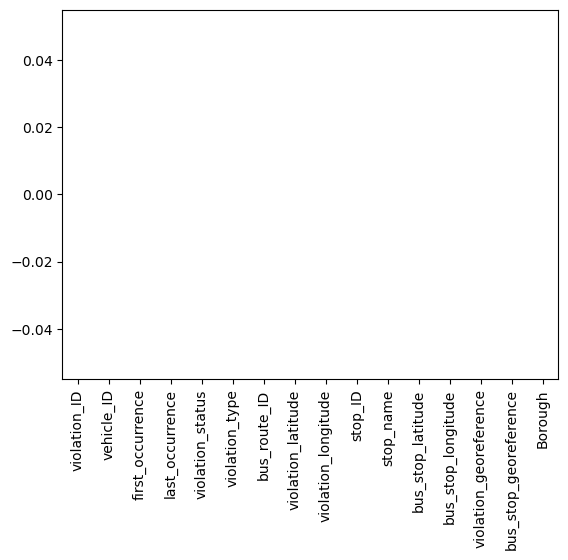

In [38]:
df.isna().sum().plot(kind='bar')

In [35]:
df.drop(['lon','lat'], axis=1, inplace=True)

In [37]:
df.dropna(inplace=True)

In [39]:
df.head()

,violation_ID,vehicle_ID,first_occurrence,last_occurrence,violation_status,violation_type,bus_route_ID,violation_latitude,violation_longitude,stop_ID,stop_name,bus_stop_latitude,bus_stop_longitude,violation_georeference,bus_stop_georeference,Borough
0,489749182,c5ae1411153b52556a1e648cc80d718aa519a4bdd189ab...,08/20/2025 11:12:08 PM,08/21/2025 12:24:08 AM,TECHNICAL ISSUE/OTHER,MOBILE BUS STOP,BX36,40.840509,-73.881189,102498,EAST TREMONT AV/VYSE AV,40.841076,-73.882483,POINT (-73.881189 40.840509),POINT (-73.882483 40.841076),BRONX
1,489744714,df9044acf85cf55488aea4cd3ce1d0e17ef050551726b6...,08/20/2025 11:48:59 PM,08/20/2025 11:54:47 PM,EXEMPT - BUS/PARATRANSIT,MOBILE BUS STOP,BX28,40.874017,-73.890646,100080,PAUL AV/BEDFORD PARK BLVD,40.874629,-73.891539,POINT (-73.890646 40.874017),POINT (-73.891539 40.874629),BRONX
2,489743631,eb5a337966ba65f66ab1db8e169d2446a4fb429b0efc63...,08/20/2025 10:33:13 PM,08/20/2025 11:56:02 PM,TECHNICAL ISSUE/OTHER,MOBILE DOUBLE PARKED,Q53+,40.721971,-73.867136,550473,WOODHAVEN BLVD/PENELOPE AV,40.722487,-73.867736,POINT (-73.867136 40.721971),POINT (-73.867736 40.722487),QUEENS
3,489741945,3f877f70d9b253515a945be807c9c62d5814949f810310...,08/20/2025 10:50:45 PM,08/20/2025 11:32:43 PM,EXEMPT - OTHER,MOBILE BUS STOP,Q44+,40.762529,-73.831728,501140,UNION ST/35 AV,40.765422,-73.827944,POINT (-73.831728 40.762529),POINT (-73.827944 40.765422),QUEENS
4,489741940,7feac037b62d591ffb1214e356157f3dd197fc22fee5bb...,08/20/2025 10:52:57 AM,08/20/2025 11:16:57 AM,EXEMPT - EMERGENCY VEHICLE,MOBILE BUS STOP,M101,40.815113,-73.955040,401458,AMSTERDAM AV/W 131 ST,40.816009,-73.954424,POINT (-73.95504 40.815113),POINT (-73.954424 40.816009),MANHATTAN


In [40]:
df.to_csv("/Users/Marcy_Student/Desktop/MTA_DATATHON/MTA_Datathon_2025/Data/final_cleaned_dataset.csv")